## Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import random
import torchvision
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

In [2]:
os.getcwd()

'/Users/danielschene/workspace/MakeAIWork3'

## Paden naar train en test data

In [3]:
path_to_train = "./data/TrainO"
path_to_test = "./data/TestO"

## Opzetten van de data met ImageFolder -> Transforms -> DataLoader

### Functie om tensor als plaatje weer te geven

In [4]:
def display_image_from_tensor(tensor):
    tensor = np.transpose(tensor, (1, 2, 0))
    plt.imshow(tensor)
    plt.axis('off')
    plt.show()

### Transformaties aangeven

In [5]:
train_transforms = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transforms = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

### ImageFolder gebruiken om de train en test sets "in te lezen", en meteen de transformaties toe te passen

In [6]:
train_set = ImageFolder(path_to_train, transform=train_transforms)
test_set = ImageFolder(path_to_test, transform=test_transforms)

In [7]:
train_set.class_to_idx

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


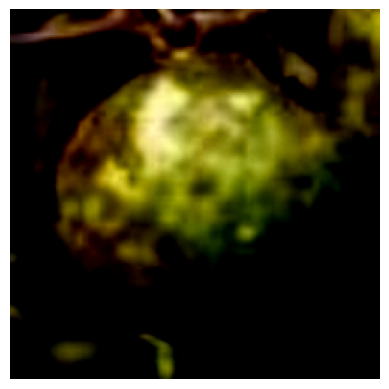

In [77]:
display_image_from_tensor(test_set[0][0])

### Dataloaders maken van de train en test sets


In [97]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)

## Opzetten van de data met Dataset class en Dataloader

In [10]:
class CustomDataset(Dataset):
    
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transforms = transform
        self.class_to_label = {}
        self.images = []
        self.labels = []

        class_names = [d for d in sorted(os.listdir(folder_path)) if os.path.isdir(os.path.join(folder_path, d))]
        
        for i, class_name in enumerate(class_names):
            class_path = os.path.join(folder_path, class_name)
            #print(i, class_name, class_path)
            
            self.class_to_label[class_name] = i
                
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(i)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        image = Image.open(image).convert("RGB")
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label
    
    def display_image_from_tensor(self):
        random_index = random.randint(0, len(self.images) - 1)
        
        img_path = self.images[random_index]
        img_label = self.labels[random_index]
        img = torchvision.io.read_image(img_path).permute(1, 2, 0)
        
        for key, value in self.class_to_label.items():
            if value == img_label:
                class_name = key
                
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis('off')
        plt.show()
    

In [98]:
train_data_fromclass = CustomDataset(path_to_train, train_transforms)
test_data_fromclass = CustomDataset(path_to_test, test_transforms)

train_loader_fromclass = DataLoader(train_data_fromclass, batch_size=8, shuffle=True)
test_loader_fromclass = DataLoader(test_data_fromclass, batch_size=8, shuffle=True)

In [99]:
train_data_fromclass.class_to_label

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


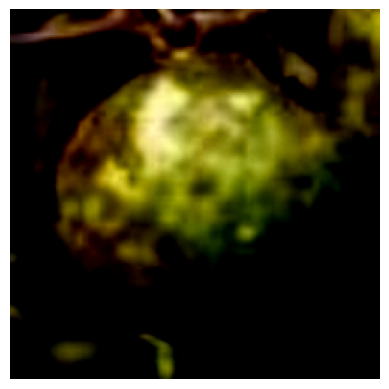

In [100]:
display_image_from_tensor(test_set[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


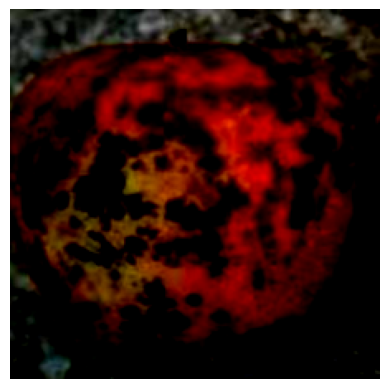

In [101]:
display_image_from_tensor(test_data_fromclass[0][0])

## Netwerk opzetten

In [102]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(100 * 56 * 56, 200)
        self.fc2 = nn.Linear(200, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [103]:
number_of_classes = 4
model_1 = CNNModel(number_of_classes)

## Device bepalen

In [91]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda'
    else:
        dev = 'cpu'
    
    return torch.device(dev)

device = set_device()
model_1 = model_1.to(device)

## Parameters & Training

In [104]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001)

In [105]:
def train_model(model, trainloader, testloader, criterion, optimizer, n_epochs):
    
    device = set_device()
    model = model.to(device)
    model.train()
    
    for n in range(n_epochs):
        print(f'Current epoch: {n+1}')
        
        running_loss = 0
        running_correct = 0
        total_predicted = 0
        
        for data in trainloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            total_predicted += labels.size(0)
            
            optimizer.zero_grad()
            output = model(images)
            
            _, predicted = torch.max(output.data, 1)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100.0 * running_correct / total_predicted
        
        
        print(f'TRAINING SET - {running_correct} out of {total_predicted} correct. Epoch accuracy is {epoch_acc}. Epoch loss is {epoch_loss}')

In [106]:
train_model(model_1, train_loader_fromclass, test_loader_fromclass, loss_function, optimizer, 25)

Current epoch: 1
TRAINING SET - 137 out of 337 correct. Epoch accuracy is 40.652818991097924. Epoch loss is 1.334535889847334
Current epoch: 2
TRAINING SET - 143 out of 337 correct. Epoch accuracy is 42.433234421364986. Epoch loss is 1.2706243908682535
Current epoch: 3
TRAINING SET - 159 out of 337 correct. Epoch accuracy is 47.18100890207715. Epoch loss is 1.2057054722031881
Current epoch: 4
TRAINING SET - 168 out of 337 correct. Epoch accuracy is 49.85163204747774. Epoch loss is 1.1604007745898046
Current epoch: 5
TRAINING SET - 181 out of 337 correct. Epoch accuracy is 53.70919881305638. Epoch loss is 1.1296256960824478
Current epoch: 6
TRAINING SET - 178 out of 337 correct. Epoch accuracy is 52.81899109792285. Epoch loss is 1.1187507219092792
Current epoch: 7
TRAINING SET - 189 out of 337 correct. Epoch accuracy is 56.083086053412465. Epoch loss is 1.082043353901353
Current epoch: 8
TRAINING SET - 188 out of 337 correct. Epoch accuracy is 55.78635014836795. Epoch loss is 1.12243902

In [107]:
def eval_model(model, testloader):
    model.eval()
    
    t_correct = 0
    
    with torch.no_grad():
        
        for data in testloader:
            images, labels = data
            images = images.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
        
            t_correct += (predicted == labels).sum().item()
    
    test_acc = (t_correct / len(test_set))*100
    print(f"Test Accuracy: {test_acc}")

In [108]:
eval_model(model_1, test_loader)

Test Accuracy: 40.833333333333336
